# Sessie 7b - Interpolatie

In [4]:
%matplotlib inline

import math
import numpy as np

from matplotlib import pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view

In [5]:
def list2column(v):
    """
    Transponeer een lijst van elementen naar een kolomvector.
    """
    return np.asmatrix(v).transpose()

def column2list(v):
    """
    Transponeer een kolomvector naar een lijst van elementen.
    """
    return np.array(v.transpose())[0]

In [6]:
def cubic_polynomial(a, b, c, d):
    """Returns a cubic function given a set of coefficients."""
    return lambda x: a * x**3 + b * x**2 + c * x + d

## 1. Cubic spline interpolatie

Bij cubic spline-interpolatie is de interpolerende functie een verzameling van stuksgewijze kubische vergelijkingen. In het bijzonder nemen we aan dat de punten $(x_i,y_i)$ en $(x_{i+1},𝑦_{i+1})$ verbonden zijn door een kubische vergelijking $f_i(x)=a_{i}x^3 + b_{i}x^2 + c_{i}x + d_i$ die geldig is voor $x_i ≤ x ≤ x_{i+1}$ voor $i=1,...,n-1$. Om de interpolerende functie te vinden, moeten we eerst de coëfficiënten $a_i, b_i, c_i,d_i$ bepalen voor elk van de kubische vergelijkingen. 

Voor $n$ punten zijn er $n-1$ kubische vergelijkingen te vinden en elke vergelijking heeft vier coëfficiënten nodig. 
Gegeven de punten $D = \{(0, 0), (2, 1.81), (5, -4.79), (8, 7.91)\}$, dan bestaat de interpolatie functie uit $|D| - 1 = 3$ kubische vergelijkingen, namelijk $f_1, f_2, f_3$. 

Bereken eerst handmatig het stelsel vergelijkingen om de datapunten te interpoleren. Implementeer dan een methode die het systeem van vergelijkingen oplost om de coefficienten te vinden. Gebruik deze dan om de stuksgewijze functie te maken die de set van kubische functies gebruikt.

Gebruik eerst de `natural spline` en dan `not-a-knot spline` conditie.

<b>ANTWOORD:</b>

Elke functie $f_i$ is een vergelijking van de derde orde. 

$$ f_{i}(x) = a_{i}x^3 + b_{i}x^2 + c_{i}x + d_{i} $$

De eerste kubische vergelijking $f_1$ gaat beide door het eerste punt en het tweede punt ($f_{1}(0) = 0, f_{1}(2)=1.81$).

Voor het linkerpunt van $f_{1}$ (dus $x = 0$)
$$ f_{1}(0) = 0 $$
$$ a_{i}0^3 + b_{i}0^2 + c_{i}0 + d_{i} = 0 $$
$$ d_{i} = 0$$

Voor het rechterpunt van $f_{2}$ (dus $x = 2$)
$$f_{1}(2) = 1.81 $$
$$ a_{i}2^3 + b_{i}2^2 + c_{i}2 + d_{i} = 1.81 $$
$$ 8a_{i} + 4b_{i} + 2c_{i} + d_{i} $$ 

Op dezelfde manier gaat $f_2$ door het tweede en derde punt en $f_3$ door het derde en vierde punt. Dit leidt tot de volgende set van vergelijkingen:

$$f_{2}(2) = 1.81$$
$$f_{2}(5) = -4.79$$
$$f_{3}(5) = -4.79$$
$$f_{3}(8) = 7.91$$

Daarbij is de eerste en tweede afgeleide van alle naburige vergelijkingen gelijk in het punt waar ze raken.

$$ f'_{i}(x) = 3a_{i}x^2 + 2b_{i}x + c_{i} $$
$$ f''_{i}(x) = 6a_{i}x + 2b_{i} $$

De functie $f_1$ raakt $f_2$ dus in het punt $x=2$. Hetzelfde geldt voor de twee andere naburige veeltermen $f_2$ en $f_3$ in $x=5$:

$$ f'_{1}(x) = f'_{2}(x)  \qquad |_{x=2} $$
$$ f'_{2}(x) = f'_{3}(x)  \qquad |_{x=5} $$

Als men de eerste afgeleide neemt in de gegeven punten, bekomt men de volgende vergelijkingen:

$$ 12a_{1} + 4b_{1} + c_1 = 12a_{2} + 4b_{2} + c_2 $$
$$ 75a_{2} + 10b_{2} + c_2 = 75a_{3} + 10b_{3} + c_3 $$

Op dezelfde manier behandelen we ook de tweede afgeleiden en bekomen:

$$ 12a_{1} + 2b_{1} = 12a_{2} + 2b_{2}  $$
$$ 30a_{2} + 2b_{2} = 30a_{3} + 2b_{3}  $$

De laatste twee vergelijkingen bekomen we door een van de twee boundary conditions (`natural spline` en `not-a-knot` splines) te gebruiken.

De `natural spline` wordt gedefinieerd als het gelijkstellen van de tweede afgeleide van de eerste en laatste veelterm op nul in de eindpunten ($x_1, x_{n+1}$) van de interpolatie functie:

$$ 2b_{1} = 0  $$
$$ 48a_{3} + 2b_{3} = 0  $$

Nu kunnen we het systeem van vergelijkingen opstellen en oplossen om de coëfficienten van de drie veeltermen te vinden. 

$$
\begin{bmatrix}
    0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    8 & 4 & 2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 8 & 4 & 2 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 125 & 25 & 5 & 1 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 125 & 25 & 5 & 1 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 512 & 64 & 8 & 1 \\
    12 & 4 & 1 & 0 & -12 & -4 & -1 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 75 & 10 & 1 & 0 & -75 & -10 & -1 & 0 \\
    12 & 2 & 0 & 0 & -12 & -2 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 30 & 2 & 0 & 0 & -30 & -2 & 0 & 0 \\
    0 & 2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 48 & 2 & 0 & 0
\end{bmatrix} 
\begin{bmatrix} a_1 \\ b_1 \\ c_1 \\ d_1 \\ a_2 \\ b_2 \\ c_2 \\ d_2 \\ a_3 \\ b_3 \\ c_3 \\ d_3 \end{bmatrix}
=
\begin{bmatrix} 0 \\ 1.81 \\ 1.81 \\ -4.79 \\ -4.79 \\ 7.91 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{bmatrix}
$$


### 1A. Natural spline

In [7]:
### CODE HERE ###

# natural spline
A1 = np.array([
    # interpolation of the points
    [0, 0, 0, 1, 0, 0, 0 ,0, 0, 0, 0 ,0],
    [8, 4, 2, 1, 0, 0, 0 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 8, 4, 2 ,1, 0, 0, 0 ,0],
    [0, 0, 0, 0, 125, 25, 5, 1, 0, 0, 0 ,0],
    [0, 0, 0, 0, 0, 0, 0 ,0, 125, 25, 5 ,1],
    [0, 0, 0, 0, 0, 0, 0 ,0, 512, 64, 8 ,1],
    # equality of the first derivatives
    [12, 4, 1, 0, -12, -4, -1 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 75, 10, 1 ,0, -75, -10, -1 ,0],
    # equality of the second derivatives
    [12, 2, 0, 0, -12, -2, 0 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 30, 2, 0 ,0, -30, -2, 0 ,0],
    # equality of the second derivative of the first and final spline (both equal to 0)
    [0, 2, 0, 0, 0, 0, 0 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 0, 0, 0 ,0, 48, 2, 0 ,0],
    ])

b1 = np.array([0, 1.81, 1.81, -4.79, -4.79, 7.91, 0, 0, 0, 0, 0, 0])

In [8]:
def cubic_spline(A, b, xis):
    """Returns a cubic spline function given a system of linear equations.
    
    Args:
        A (np.array): matrix of variable coefficients
        b (np.array): constant terms of the equations
        xis (np.array[float]): x-values of the data used to derive the spline function

    Returns:
        callable: cubic spline function
    """
    ### CODE HERE ###
    # part 1: solve the system of equations to find the coefficients
    coeffs = np.linalg.solve(A, b)
    coeffs = np.split(coeffs, len(b) // 4) # split the coefficients into chunks of (a,b,c,d)
    fs = [cubic_polynomial(a, b, c, d) for (a, b, c, d) in coeffs]
    
    # part 2: create the piecewise cubic spline function
    windows = sliding_window_view(xis, 2)
    def cs(x):
        if x < xis[0]:
            f = fs[0] # use first cubic function
        elif x > xis[-1]:
            f = fs[-1] # use last cubic function
        else:
            # find cubic function that interpolates the given value (by checking the window)
            for idx, (low, high) in enumerate(windows, 0):
                if low <= x <= high:
                    f = fs[idx] 
                    break
        return f(x)
    return cs

(-10.0, 15.0)

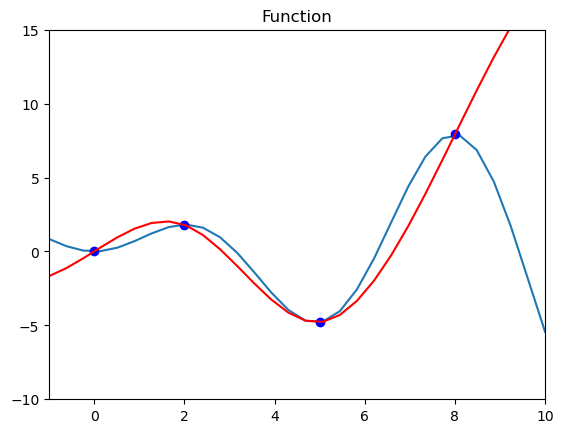

In [9]:
### TEST ###

# Function f
f = lambda x: x*math.sin(x)
xs = np.linspace(-1, 10, 30)
fs = list(map(f, xs))
plt.title('Function')
plt.plot(xs, fs)

# Data points (xi, fi)
xis = [0, 2, 5, 8]
fis = list(map(f, xis))
plt.plot(xis, fis, 'bo')

# Interpolate through (xi, fi) with natural cubic spline interpolation
cs = cubic_spline(A1, b1, xis)
ys = list(map(cs, xs))
plt.plot(xs, ys, color="red")
plt.xlim(-1, 10)
plt.ylim(-10, 15)

### 1B. Not-a-knot spline

Anders, kunnen de boundary conditions gedefinieerd met `not-a-knot spline` door de derde afgeleide van de eerste twee splines (in dit geval $f_1$ en $f_2$) en de laatste twee splines (in dit geval $f_2$ en $f_3$) gelijk te stellen in. Met andere woorden:

$$ f'''_{i}(x) = 6a_i $$

$$ f'''_{1}(x) = f'''_{2}(x)  \qquad |_{x=2} $$
$$ f'''_{2}(x) = f'''_{3}(x)  \qquad |_{x=5} $$

$$ 6a_{1} = 6a_{2}  $$
$$ 6a_{2} = 6a_{3}  $$

In [11]:
### CODE HERE ###

# not-a-knot
A2 = np.array([
    # interpolation of the points
    [0, 0, 0, 1, 0, 0, 0 ,0, 0, 0, 0 ,0],
    [8, 4, 2, 1, 0, 0, 0 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 8, 4, 2 ,1, 0, 0, 0 ,0],
    [0, 0, 0, 0, 125, 25, 5, 1, 0, 0, 0 ,0],
    [0, 0, 0, 0, 0, 0, 0 ,0, 125, 25, 5 ,1],
    [0, 0, 0, 0, 0, 0, 0 ,0, 512, 64, 8 ,1],
    # equality of the first derivatives
    [12, 4, 1, 0, -12, -4, -1 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 75, 10, 1 ,0, -75, -10, -1 ,0],
    # equality of the second derivatives
    [12, 2, 0, 0, -12, -2, 0 ,0, 0, 0, 0 ,0],
    [0, 0, 0, 0, 30, 2, 0 ,0, -30, -2, 0 ,0],
    # equality (of 0) of the third derivative of the first and final spline
    [6, 0, 0, 0, -6, 0, 0 ,0, 0, 0, 0 ,0], # different!
    [0, 0, 0, 0, 6, 0, 0 ,0, -6, 0, 0 ,0], # different!
    ])
# given
b2 = np.array([0, 1.81, 1.81, -4.79, -4.79, 7.91, 0, 0, 0, 0, 0, 0])

(-10.0, 15.0)

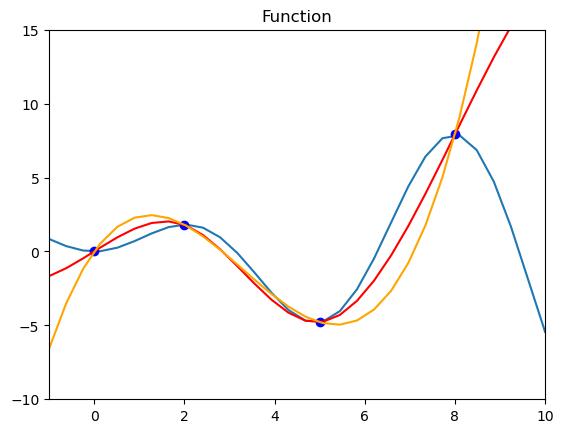

In [12]:
### TEST ###

# Function f
f = lambda x: x*math.sin(x)
xs = np.linspace(-1, 10, 30)
fs = list(map(f, xs))
plt.title('Function')
plt.plot(xs, fs)

# Data points (xi, fi)
xis = [0, 2, 5, 8]
fis = list(map(f, xis))
plt.plot(xis, fis, 'bo')

# Interpolate through (xi, fi) with natural cubic spline interpolation
cs = cubic_spline(A1, b1, xis)
ys = list(map(cs, xs))
plt.plot(xs, ys, color="red")

# Interpolate through (xi, fi) with not-a-knot cubic spline interpolation
cs = cubic_spline(A2, b2, xis)
ys = list(map(cs, xs))
plt.plot(xs, ys, color="orange")

plt.xlim(-1, 10)
plt.ylim(-10, 15)